## Fresh and rotten fruits for classification

## Objective

 To train a neural network model that can distinguish between fresh and rotten fruits as a classification problem. 

## Datasets (Source & Acknowledgements)

1. An extensive dataset for successful recognition of fresh and rotten fruits 
Sultana, Nusrat; Jahan, Musfika; Uddin, Mohammad Shorif (2022) Data in Brief 44: 108552 </br>
Dataset: “Fresh and Rotten Fruits Dataset for Machine-Based Evaluation of Fruit Quality”, Mendeley Data, V1, doi: 10.17632/bdd69gyhv8.1 </br>
https://www.sciencedirect.com/science/article/pii/S2352340922007594 </br>

2. Fruits fresh and rotten for classification 
https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification </br>
https://www.kaggle.com/code/alexanderrudyak/classifying-rotten-fruits </br>

In [1]:
## Import Libraries
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from distutils.dir_util import copy_tree
import glob
import shutil
import os
from os import path
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

## Compile the images into the folders for training, validating and testing

1. Publication Mendeley dataset: 

Fruit images from the fresh apple, rotten apple, fresh banana, rotten banana, fresh orange, rotten orange categories are used for training, validating and testing, with a few unseen/novel images from fresh guava, rotten guava, fresh pomegranate, rotten pomegranate categories used for testing. </br> 

Original images and Augmented image files (renamed with a prefix "Aug") are distributed into folders for both freshfruits and rottenfruits, and some images are placed into a test2 folder for testing. </br>

2. Kaggle dataset: 

Fruit images from the fresh apple, rotten apple, fresh banana, rotten banana, fresh orange, rotten orange categories are used for training and validating. </br>

Images are distributed into folders for both freshfruits and rottenfruits, and some are placed into a test2 folder for testing

## Augment images

In [2]:
# use Keras' ImageDataGenerator to generate augmented images to increase dataset size

train_datagenerator = ImageDataGenerator(
rescale=1/255.0,
rotation_range = 10,
zoom_range = 0.1,
shear_range=0.1,
width_shift_range = 0.1,
height_shift_range = 0.1,
horizontal_flip = True,
vertical_flip = False,
validation_split=0.2)

valid_datagenerator = ImageDataGenerator(
rescale=1/255.0)

## Load and iterate both training and validation datasets

In [3]:
# load and iterate training dataset
train_generator = train_datagenerator.flow_from_directory(
    "./data",
    subset="training",
    target_size=(224,224),
    batch_size= 16,
    interpolation="bilinear",
    color_mode="rgb",
    class_mode="binary",
)

# load and iterate validation dataset
valid_generator = train_datagenerator.flow_from_directory(
    "./data",
    subset="validation",
    target_size=(224,224),  
    batch_size= 16,
    interpolation="bilinear",
    color_mode="rgb",
    class_mode="binary",
)

Found 12508 images belonging to 2 classes.
Found 3125 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'fresh': 0, 'rotten': 1}

In [5]:
# Dictionary with key and correct values as labels
image_class_dict={0:'fresh',
 1:'rotten'}

## Plot the fruit images in the training dataset

In [6]:
# Ploting Images
def plot_images():
    images,labels=train_generator.next()
    plt.figure(figsize=(20,10))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(image_class_dict[labels[i]])

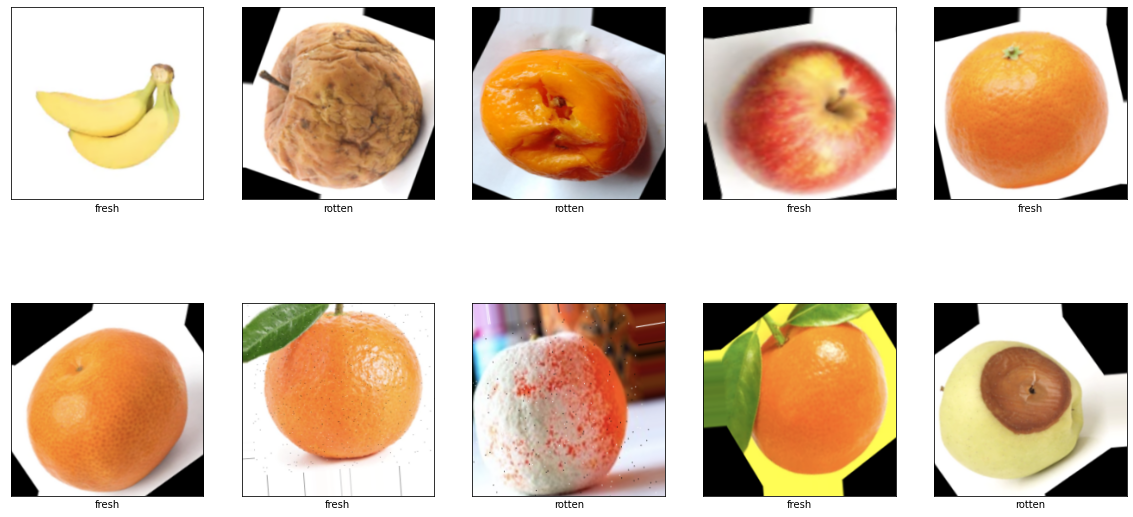

In [7]:
plot_images()

## Load ImageNet Base Model

In [8]:
# Load MobileNet V2 as the base model
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

## Freeze the base model 

In [9]:
# Freeze base model so that all the pre-trained learning from the ImageNet dataset are retained in the initial training.
base_model.trainable = False

## Add layers to the model

In [10]:
# Create inputs with correct shape
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training=False)

# Add global average pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer with one unit neuron for binary classification using sigmoid as the activation function
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [11]:
# model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## Compile the model

In [12]:
# use binary crossentropy for binary classification and assess the performance using accuracy as the metrics
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss = 'BinaryCrossentropy', metrics = ['accuracy'])

In [13]:
# use EarlyStopping in the case when val_accuracy reaches a plateau (not improving much)
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=2, 
    min_delta = 0.001)

# create model checkpoint callback to save the best model checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Training the model

In [14]:
# train the model for 10 iterations
history = model.fit(train_generator,
          validation_data=valid_generator,
          steps_per_epoch=train_generator.samples/train_generator.batch_size,
          validation_steps=valid_generator.samples/valid_generator.batch_size,
          epochs=10, callbacks=[es, model_checkpoint_callback])

Epoch 1/10
781/781 [==============================] - 357s 453ms/step - loss: 0.2080 - accuracy: 0.9198 - val_loss: 0.3155 - val_accuracy: 0.8851
Epoch 2/10
781/781 [==============================] - 352s 450ms/step - loss: 0.1045 - accuracy: 0.9643 - val_loss: 0.2495 - val_accuracy: 0.9155
Epoch 3/10
781/781 [==============================] - 353s 451ms/step - loss: 0.0808 - accuracy: 0.9737 - val_loss: 0.2390 - val_accuracy: 0.9056
Epoch 4/10
781/781 [==============================] - 354s 453ms/step - loss: 0.0683 - accuracy: 0.9788 - val_loss: 0.2183 - val_accuracy: 0.9174
Epoch 5/10
781/781 [==============================] - 354s 452ms/step - loss: 0.0603 - accuracy: 0.9814 - val_loss: 0.2068 - val_accuracy: 0.9162
Epoch 6/10
781/781 [==============================] - 355s 454ms/step - loss: 0.0531 - accuracy: 0.9837 - val_loss: 0.1995 - val_accuracy: 0.9235
Epoch 7/10
781/781 [==============================] - 355s 454ms/step - loss: 0.0475 - accuracy: 0.9852 - val_loss: 0.1957 -

## Evaluate the model

In [15]:
# evaluate the model
model.evaluate(valid_generator, steps=valid_generator.samples/valid_generator.batch_size)

195/195 [==============================] - 75s 384ms/step - loss: 0.1974 - accuracy: 0.9229


[0.19738304615020752, 0.9228799939155579]

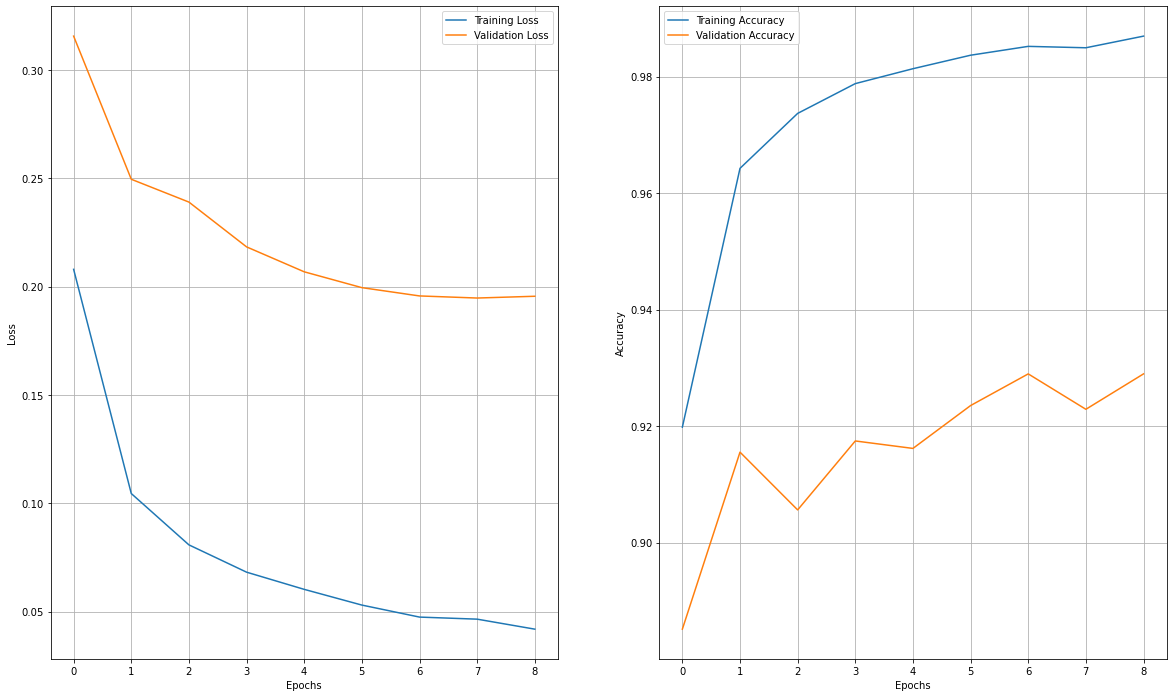

In [16]:
# plot the training/validation loss and the training/validation accuracy curves for comparison
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

## Load and test a new image

In [17]:
# define a function that takes in an image and display it
def show_test_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

## Preprocess the test image and perform predictions on it

In [18]:
# define a function that preprocess an image and perform predictions on it
def predictions(image_path):
    show_test_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

In [19]:
# define a function that states and classifies whether a fruit image is fresh or rotten based on its probability score
def is_fresh_or_rotten(image_path):
    preds = predictions(image_path)
    print(preds)
    if preds <= 0.5:
        print("It's Fresh and Edible!")
    else:
        print("It's Rotten and Inedible!")

## Sampling the test images

1/1 [==============================] - 1s 705ms/step
[[0.01163072]]
It's Fresh and Edible!


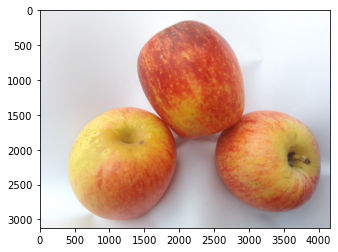

In [20]:
is_fresh_or_rotten('./test2/FreshApple (29).jpg')

1/1 [==============================] - 0s 47ms/step
[[0.9823391]]
It's Rotten and Inedible!


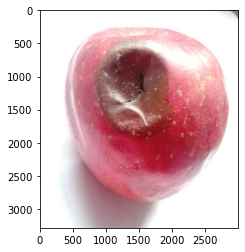

In [21]:
is_fresh_or_rotten('./test2/RottenApple (20).jpg')

1/1 [==============================] - 0s 31ms/step
[[0.03993352]]
It's Fresh and Edible!


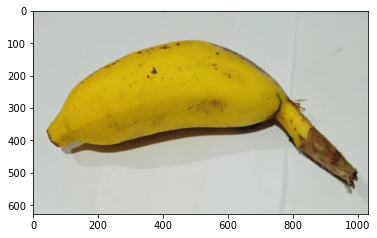

In [22]:
is_fresh_or_rotten('./test2/FreshBanana (65).jpg')

1/1 [==============================] - 0s 47ms/step
[[0.5127751]]
It's Rotten and Inedible!


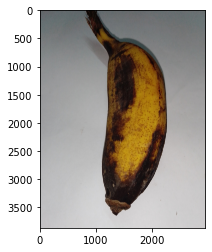

In [23]:
is_fresh_or_rotten('./test2/RottenBanana (121).jpg')

1/1 [==============================] - 0s 43ms/step
[[0.6190863]]
It's Rotten and Inedible!


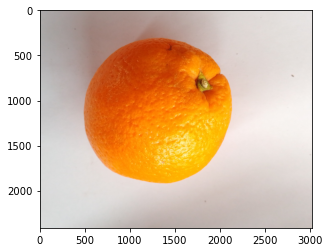

In [24]:
is_fresh_or_rotten('./test2/FreshOrange (173).jpg')

1/1 [==============================] - 0s 47ms/step
[[0.9501926]]
It's Rotten and Inedible!


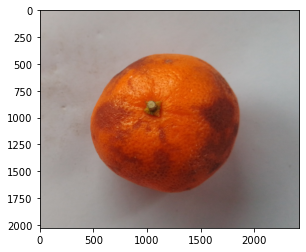

In [25]:
is_fresh_or_rotten('./test2/RottenOrange (60).jpg')

## Sampling images of previously untrained/unseen fruit categories

1/1 [==============================] - 0s 31ms/step
[[0.13853979]]
It's Fresh and Edible!


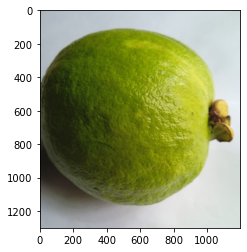

In [26]:
is_fresh_or_rotten('./test2/FreshGuava (7).jpg')

1/1 [==============================] - 0s 41ms/step
[[0.97461176]]
It's Rotten and Inedible!


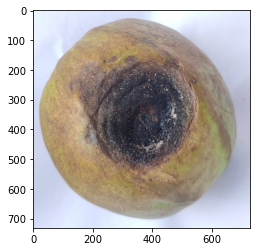

In [27]:
is_fresh_or_rotten('./test2/RottenGuava (134).jpg')

1/1 [==============================] - 0s 31ms/step
[[0.10546966]]
It's Fresh and Edible!


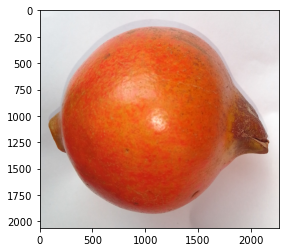

In [28]:
is_fresh_or_rotten('./test2/FreshPomegranate (12).jpg')

1/1 [==============================] - 0s 34ms/step
[[0.94747365]]
It's Rotten and Inedible!


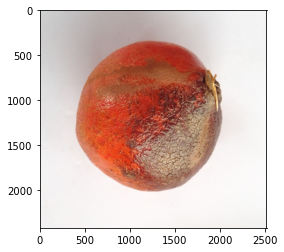

In [29]:
is_fresh_or_rotten('./test2/RottenPomegranate (18).jpg')

## Conclusion

Classification of the fruit images is mostly accurate for the pre-trained MobileNet V2 model, based on its low validation loss of 0.0692 and high validation accuracy of 0.9757 for 10 epochs. 

## End of Notebook